# BlowBy Diagnosis
Context : PSA request blowby diag for USA & Korea applications. Current platform SW do not match PSA specs.

Different engine Fields has been performed with different configurations.
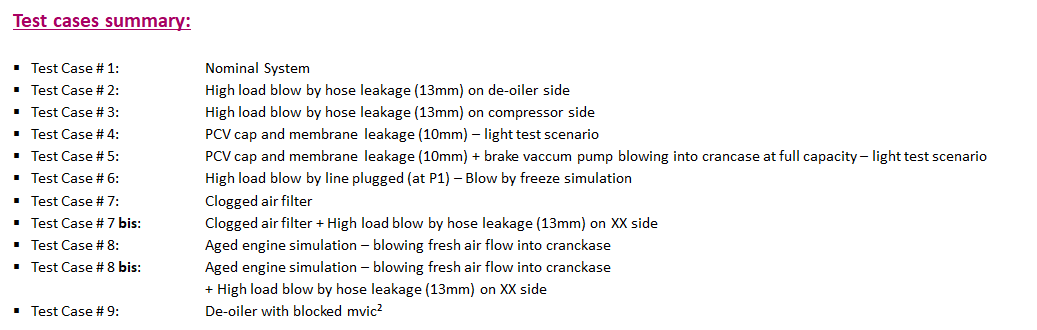
Test cases 1, 7 and 8 should be not diaged
Test cases 2, 3, 7bis and 8bis should be diaged

In the CSV files of train / test sets are described bellow :

For all the datasets :
 - col 1 : RPM
 - col 2 : load
 - col 3 : conf (number in [1 2 3 7 8 10 11]) > 7 classes corresponding to the engine field
 - col 4 : if the blowby is leaking or not (number in [0 1]) > binary classification
 - col 5 : engine Load
 - col 5 > 51 : 46 * 5 Cranck angle based Pressure for new sensor in the blowby system
 - col 52 > 98 : 46 * 5 Cranck angle based Pressure for Outlet compressor sensor
 - 99 > 145 : 46 * 5 Cranck angle based Pressure for inlet manifold sensor
 

Here is a snaphot of the data @ 750 RPM :

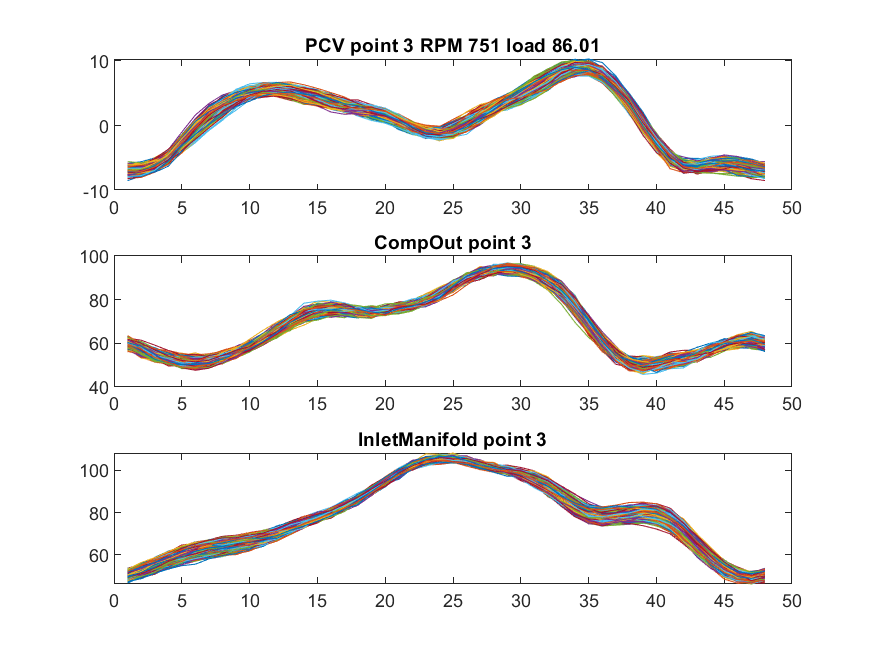


Here is a snapshot of the data @ 5000 RPM :

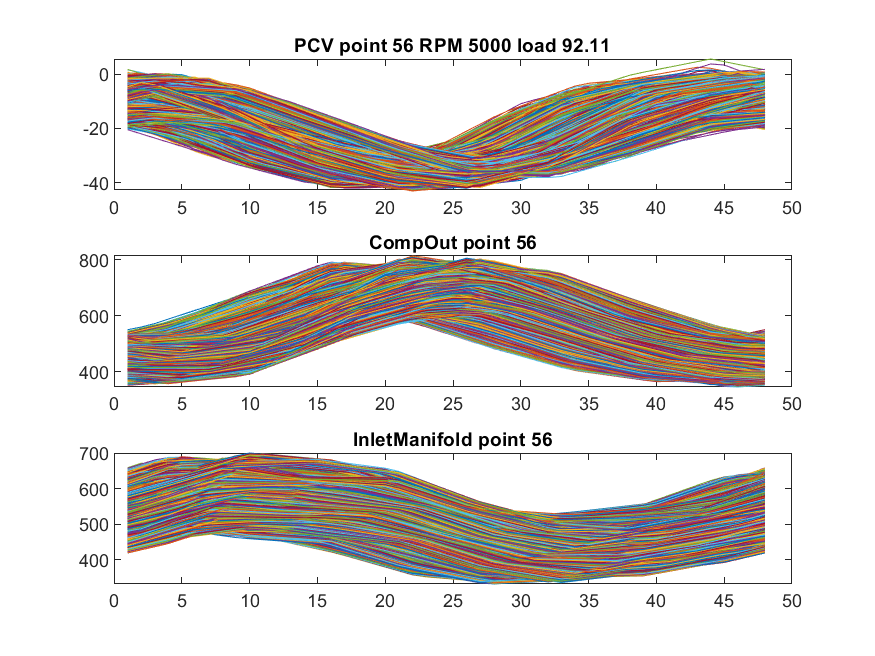


We can see the 5000 RPM data seems a lot less precise, due to the fact it is 1ms interpolated data. (1 ms is 33 CAD at 5000 RPM)

# Datasets 

 - DS1 : same OP
 - DS2 : different OP

In [ ]:
import sklearn

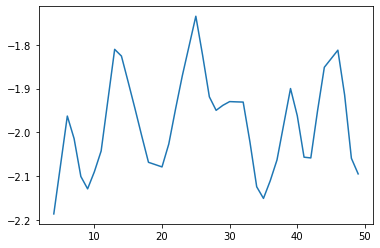

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('TrainSet1_sameOP.csv', header=None)
test = pd.read_csv('TestSet1_sameOP.csv', header=None)

data = data.rename(columns = {0:'RPM',1:'load',2:'conf',3:'bin'})
test = test.rename(columns = {0:'RPM',1:'load',2:'conf',3:'bin'})

one = data.iloc[:,4:50] # compressor outlet pressure
two = data.iloc[:,51:97] # inlet manifold pressure
three = data.iloc[:,98:144] # new PCV sensor

dic_map_class = {1:"1",
                2:"2",
                3:"3",
                4:"4",
                5:"5",
                6:"5bis",
                7:"7",
                8:"8bis",
                9:"9",
                10:"8",
                11:"7bis"}

def mapping(inp):
    return dic_map_class[inp]

data["class_target_str"] = data["conf"].apply(mapping)
test["class_target_str"] = test["conf"].apply(mapping)

def myround(x, base=50):
    return base * round(x/base)
data['round_RPM'] = data['RPM'].apply(myround)
test['round_RPM'] = test['RPM'].apply(myround)

one.iloc[1,:].plot()

data=data.dropna()
data=data[(data['round_RPM'] < 3500) & (data['load']>30) & (data['round_RPM'] >1400)]
test=test.dropna()
test=test[(test['round_RPM'] < 3500) & (test['load']>30) & (test['round_RPM'] >1400)]

In [2]:
X_train = data.drop(['conf','bin','class_target_str','round_RPM'], axis=1).dropna()[data.dropna()['round_RPM'] < 3500]
X_test = test.drop(['conf','bin','class_target_str','round_RPM'], axis=1).dropna()
y_train = data.dropna()['bin']
y_test = test.dropna()['bin']
conf_train = data.dropna()['class_target_str']
conf_test = test.dropna()['class_target_str']
print(X_train.shape)
print(y_train.shape)
X_train.head()

(234301, 143)
(234301,)


,RPM,load,4,5,6,7,8,9,10,11,...,135,136,137,138,139,140,141,142,143,144
16414,1499.4,31.759,-1.4216,-1.3352,-1.2491,-1.16370,-0.91733,-0.52674,-0.28768,-0.09588,...,-344.15,-332.11,-318.54,-299.87,-282.87,-267.85,-258.80,-252.44,-251.51,-251.55
16415,1499.4,31.759,-1.3681,-1.3231,-1.1219,-0.96334,-0.82952,-0.65475,-0.48898,-0.45058,...,-349.88,-339.67,-324.06,-305.89,-286.05,-272.85,-261.56,-257.92,-255.75,-256.79
16416,1499.4,31.759,-1.2184,-1.3006,-1.2095,-1.06890,-0.79906,-0.61281,-0.62157,-0.55977,...,-354.24,-344.82,-327.62,-309.82,-290.34,-276.21,-267.12,-264.55,-264.02,-265.69
16417,1499.4,31.759,-1.4354,-1.3137,-1.1899,-1.06380,-0.95126,-0.84461,-0.67303,-0.50886,...,-352.32,-339.61,-325.60,-306.71,-289.91,-276.54,-267.79,-262.12,-260.78,-260.53
16418,1499.4,31.759,-1.3973,-1.2214,-1.1389,-1.01240,-0.84751,-0.61073,-0.35705,-0.27070,...,-346.45,-334.03,-317.05,-299.00,-280.40,-269.26,-260.07,-257.58,-256.77,-258.55


In [3]:
# scaling of the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_trainS = scaler.transform(X_train)
X_testS = scaler.transform(X_test)

The next block is full of helper functions

In [4]:
feature_eng = ['round_RPM','load','min_s1','min_s2','min_s3',
                            'max_s1','max_s2','max_s3',
                            'mean_s1','mean_s2','mean_s3',
                            'std_s1','std_s2','std_s3']

In [5]:
#3 sensors config
# sel_input = [ True,  True,  True, False, False, False, False, False,  True,  True, False, False,
#  False, False]

#2 sensors config 
sel_input = [ True,#1  
             True,  #2
             False, #3
             True, #4
             False, #5
             False, #6
             False, #7
             False,#8
             False,#9
             True,#10
             True,#11
             False,#12
             False,#13
            False]#14


one = data.iloc[:,4:50] # compressor outlet pressure
two = data.iloc[:,51:97] # inlet manifold pressure
three = data.iloc[:,98:144]
standard_pressure = 1013.25 # bar
    
data['min_s1'] = one.min(axis=1)
data['min_s2'] = two.min(axis=1)+standard_pressure
data['min_s3'] = three.min(axis=1)+standard_pressure
data['max_s1'] = one.max(axis=1)
data['max_s2'] = two.max(axis=1)+standard_pressure
data['max_s3'] = three.max(axis=1)+standard_pressure
data['mean_s1'] = one.mean(axis=1)
data['mean_s2'] = two.mean(axis=1)+standard_pressure
data['mean_s3'] = three.mean(axis=1)+standard_pressure
data['std_s1'] = one.std(axis=1)
data['std_s2'] = two.std(axis=1)
data['std_s3'] = three.std(axis=1)

one = test.iloc[:,4:50] # compressor outlet pressure
two = test.iloc[:,51:97] # inlet manifold pressure
three = test.iloc[:,98:144]

test['min_s1'] = one.min(axis=1)
test['min_s2'] = two.min(axis=1)+standard_pressure
test['min_s3'] = three.min(axis=1)+standard_pressure
test['max_s1'] = one.max(axis=1)
test['max_s2'] = two.max(axis=1)+standard_pressure
test['max_s3'] = three.max(axis=1)+standard_pressure
test['mean_s1'] = one.mean(axis=1)
test['mean_s2'] = two.mean(axis=1)+standard_pressure
test['mean_s3'] = three.mean(axis=1)+standard_pressure
test['std_s1'] = one.std(axis=1)
test['std_s2'] = two.std(axis=1)
test['std_s3'] = three.std(axis=1)

features_eng = ['round_RPM','load','min_s1','min_s2','min_s3',
                            'max_s1','max_s2','max_s3',
                            'mean_s1','mean_s2','mean_s3',
                            'std_s1','std_s2','std_s3']
# result = LOO_loop_feat(sel_input=sel_input, feature_eng=feature_eng, epochs=3, net=15, verbose = 1, path='field_bound.csv')

# Lattice test

In [6]:
X_trainS_resample = np.array(data[features_eng])[:,sel_input]
X_testS_resample = np.array(test[features_eng])[:,sel_input]

In [7]:
input_df = pd.DataFrame(X_trainS_resample, columns=['round_RPM', 'load', 'min_s2','mean_s2','mean_s3'])
test_df = pd.DataFrame(X_testS_resample, columns=['round_RPM', 'load', 'min_s2','mean_s2','mean_s3'])
input_df = input_df.assign(y=y_train.values)
test_df = test_df.assign(y=y_test.values)

In [8]:
input_df.head()

,round_RPM,load,min_s2,mean_s2,mean_s3,y
0,1500.0,31.759,1015.340600,1016.774437,688.189130,0
1,1500.0,31.759,1015.371500,1016.651504,683.569783,0
2,1500.0,31.759,1014.607900,1016.754370,677.921087,0
3,1500.0,31.759,1014.127810,1015.982396,675.594348,0
4,1500.0,31.759,1013.161115,1015.713984,681.948261,0


In [9]:
test_df.head()

,round_RPM,load,min_s2,mean_s2,mean_s3,y
0,1500.0,31.759,1014.53940,1016.709935,682.791739,0
1,1500.0,31.759,1014.83750,1016.647015,674.858261,0
2,1500.0,31.759,1014.13729,1016.074578,670.040000,0
3,1500.0,31.759,1014.01244,1015.709228,672.971087,0
4,1500.0,31.759,1013.88653,1015.794357,675.241087,0


In [10]:
def get_input_fn_law(input_df, num_epochs, batch_size=None):
  """Gets TF input_fn for law school models."""
  return tf.compat.v1.estimator.inputs.pandas_input_fn(
      x=input_df[['round_RPM', 'load', 'min_s2','mean_s2','mean_s3']],
      y=input_df['y'],
      num_epochs=num_epochs,
      batch_size=batch_size or len(input_df),
      shuffle=False)

In [11]:
def get_feature_columns_and_configs_law(monotonicity):
  """Gets TFL feature configs for law school models."""
  feature_columns = [
      tf.feature_column.numeric_column('round_RPM'),
      tf.feature_column.numeric_column('load'),
      tf.feature_column.numeric_column('min_s2'),
      tf.feature_column.numeric_column('mean_s2'),
      tf.feature_column.numeric_column('mean_s3'),
  ]
  feature_configs = [
      tfl.configs.FeatureConfig(
          name='round_RPM',
          lattice_size=2,
          pwl_calibration_num_keypoints=20,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
      tfl.configs.FeatureConfig(
          name='load',
          lattice_size=2,
          pwl_calibration_num_keypoints=20,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
      tfl.configs.FeatureConfig(
          name='min_s2',
          lattice_size=2,
          pwl_calibration_num_keypoints=20,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
      tfl.configs.FeatureConfig(
          name='mean_s2',
          lattice_size=2,
          pwl_calibration_num_keypoints=20,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
      tfl.configs.FeatureConfig(
          name='mean_s3',
          lattice_size=2,
          pwl_calibration_num_keypoints=20,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
  ]
  return feature_columns, feature_configs

In [12]:
def train_tfl_estimator(train_df, monotonicity, learning_rate, num_epochs,
                        batch_size, get_input_fn,
                        get_feature_columns_and_configs):
  """Trains a TFL calibrated linear estimator.

  Args:
    train_df: pandas dataframe containing training data.
    monotonicity: if 0, then no monotonicity constraints. If 1, then all
      features are constrained to be monotonically increasing.
    learning_rate: learning rate of Adam optimizer for gradient descent.
    num_epochs: number of training epochs.
    batch_size: batch size for each epoch. None means the batch size is the full
      dataset size.
    get_input_fn: function that returns the input_fn for a TF estimator.
    get_feature_columns_and_configs: function that returns TFL feature columns
      and configs.

  Returns:
    estimator: a trained TFL calibrated linear estimator.

  """
  feature_columns, feature_configs = get_feature_columns_and_configs(
      monotonicity)

  model_config = tfl.configs.CalibratedLinearConfig(
      feature_configs=feature_configs, use_bias=False)

  estimator = tfl.estimators.CannedClassifier(
      feature_columns=feature_columns,
      model_config=model_config,
      feature_analysis_input_fn=get_input_fn(input_df=train_df, num_epochs=1),
      optimizer=tf.keras.optimizers.Adam(learning_rate))

  estimator.train(
      input_fn=get_input_fn(
          input_df=train_df, num_epochs=num_epochs, batch_size=batch_size))
  return estimator


def optimize_learning_rates(
    train_df,
    test_df,
    monotonicity,
    learning_rates,
    num_epochs,
    batch_size,
    get_input_fn,
    get_feature_columns_and_configs,
):
  """Optimizes learning rates for TFL estimators.

  Args:
    train_df: pandas dataframe containing training data.
    val_df: pandas dataframe containing validation data.
    test_df: pandas dataframe containing test data.
    monotonicity: if 0, then no monotonicity constraints. If 1, then all
      features are constrained to be monotonically increasing.
    learning_rates: list of learning rates to try.
    num_epochs: number of training epochs.
    batch_size: batch size for each epoch. None means the batch size is the full
      dataset size.
    get_input_fn: function that returns the input_fn for a TF estimator.
    get_feature_columns_and_configs: function that returns TFL feature columns
      and configs.

  Returns:
    A single TFL estimator that achieved the best validation accuracy.
  """
  estimators = []
  train_accuracies = []
  val_accuracies = []
  test_accuracies = []
  for lr in learning_rates:
    estimator = train_tfl_estimator(
        train_df=train_df,
        monotonicity=monotonicity,
        learning_rate=lr,
        num_epochs=num_epochs,
        batch_size=batch_size,
        get_input_fn=get_input_fn,
        get_feature_columns_and_configs=get_feature_columns_and_configs)
    estimators.append(estimator)
    train_acc = estimator.evaluate(
        input_fn=get_input_fn(train_df, num_epochs=1))['accuracy']
    test_acc = estimator.evaluate(
        input_fn=get_input_fn(test_df, num_epochs=1))['accuracy']
    print('accuracies for learning rate %f: train: %f, test: %f' %
          (lr, train_acc, test_acc))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
  max_index = train_accuracies.index(max(train_accuracies))
  return estimators[max_index]


In [13]:
def plot_maps(model_graph):
    fig, axs = plt.subplots(2, 3)
    axs[0, 0].plot(model_graph.nodes[5].input_keypoints, model_graph.nodes[5].output_keypoints)
    axs[0, 0].set_title(model_graph.nodes[5].input_node.name)
    axs[0, 1].plot(model_graph.nodes[6].input_keypoints, model_graph.nodes[6].output_keypoints)
    axs[0, 1].set_title(model_graph.nodes[6].input_node.name)
    axs[0, 2].plot(model_graph.nodes[7].input_keypoints, model_graph.nodes[7].output_keypoints)
    axs[0, 2].set_title(model_graph.nodes[7].input_node.name)
    axs[1, 0].plot(model_graph.nodes[8].input_keypoints, model_graph.nodes[8].output_keypoints)
    axs[1, 0].set_title(model_graph.nodes[8].input_node.name)
    axs[1, 1].plot(model_graph.nodes[9].input_keypoints, model_graph.nodes[9].output_keypoints)
    axs[1, 1].set_title(model_graph.nodes[9].input_node.name)

In [14]:
# nb de paramètrs : 20*2*5 = 200
def train_lattice(NUM_EPOCHS, learning_rates, monotonicity=0):
    
    
    # créer la fonction pour changer la taille des maps.
    # 
    
    feature_columns = [
      tf.feature_column.numeric_column('round_RPM'),
      tf.feature_column.numeric_column('load'),
      tf.feature_column.numeric_column('min_s2'),
      tf.feature_column.numeric_column('mean_s2'),
      tf.feature_column.numeric_column('mean_s3'),
  ]
    
    BATCH_SIZE = input_df.shape[0]
    nomon_linear_estimator = optimize_learning_rates(
        train_df=input_df,
        test_df=test_df,
        monotonicity=0,
        learning_rates=learning_rates,
        batch_size=BATCH_SIZE,
        num_epochs=NUM_EPOCHS,
        get_input_fn=get_input_fn_law,
        get_feature_columns_and_configs=get_feature_columns_and_configs_law)
    saved_model_path = nomon_linear_estimator.export_saved_model(
      "\\Users\\RUF1SO\\OneDrive - Robert Bosch GmbH\\Projets\\PSA_Blowby\\traitement\\angle_based\\lattice",
      tf.estimator.export.build_parsing_serving_input_receiver_fn(
          feature_spec=tf.feature_column.make_parse_example_spec(
              feature_columns)))
    model_graph = tfl.estimators.get_model_graph(saved_model_path)
    plot_maps(model_graph)
    

In [23]:
import tensorflow as tf
import tensorflow_lattice as tfl
from matplotlib import pyplot as plt
train_lattice(NUM_EPOCHS=100, learning_rates=[0.01])

ModuleNotFoundError: No module named 'tensorflow_lattice'

In [17]:
train_lattice(NUM_EPOCHS=300, learning_rates=[0.01])

NameError: name 'tfl' is not defined

In [18]:
train_lattice(NUM_EPOCHS=1000, learning_rates=[0.01])

NameError: name 'tfl' is not defined

In [19]:
train_lattice(NUM_EPOCHS=2000, learning_rates=[0.01])

NameError: name 'tfl' is not defined

compare de la lattice avec 3 capteurs
2000 epochs :
3 senors : 89% // 2 sensors 81%